In [ ]:
# # Run this cell if you haven't installed yahoo finance library
# pip install yfinance

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout

In [8]:
#Define ticker and start date for stock
#End date is latest by default
ticker = 'AAPL' #Apple stock
start_date = '2010-01-01'

# Fetch data
data = yf.download(ticker, start=start_date)

[*********************100%***********************]  1 of 1 completed


In [9]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2010-01-04 00:00:00+00:00,6.454505,7.643214,7.660714,7.585000,7.622500,493729600
2010-01-05 00:00:00+00:00,6.465665,7.656429,7.699643,7.616071,7.664286,601904800
2010-01-06 00:00:00+00:00,6.362819,7.534643,7.686786,7.526786,7.656429,552160000
2010-01-07 00:00:00+00:00,6.351057,7.520714,7.571429,7.466071,7.562500,477131200
2010-01-08 00:00:00+00:00,6.393281,7.570714,7.571429,7.466429,7.510714,447610800


<Axes: xlabel='Date'>

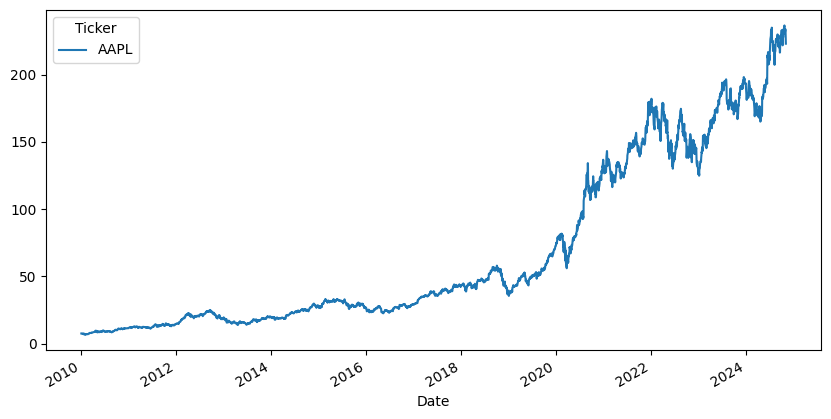

In [22]:
data['Close'].plot(figsize=(10,5))

In [23]:
#We will predict based on close price for stocks
new_data = data['Close']
new_data.shape

(3734, 1)

In [24]:
#Scale the data
scaler = MinMaxScaler()
sc_data = scaler.fit_transform(np.array(new_data).reshape(-1,1))

#Split data into train and test
train = sc_data[:int(0.8*len(sc_data))] #80%
test = sc_data[int(0.8*len(sc_data)):] #20%

print(len(train), len(test))

2987 747


In [25]:
#Convert an array of values into a dataset matrix

# dataX[i] = [dataX[i], dataX[i+1], dataX[i+2], ...., dataX[i+time_step]], dataY[i] = dataX[i+time_step+1]
# Use previous time_step values (X) as training values and time_step+1 th value (Y) as label

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [48]:
#We will use past 100 values to predict 101th value
timestamps = 100
x_train, y_train = create_dataset(train, timestamps)
x_test, y_test = create_dataset(test, timestamps)

In [49]:
print(x_train.shape, x_test.shape)

(2886, 100) (646, 100)


In [50]:
#Define LSTM model and train on training data
model = Sequential([
    InputLayer(input_shape=(x_train.shape[1],1)),
    LSTM(64,return_sequences=True),
    Dropout(0.3),
    LSTM(64,return_sequences=False),
    Dropout(0.3),
    Dense(32),
    Dense(1)
])

model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()
model.fit(x_train,y_train,epochs=10,batch_size=32,verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 100, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0080
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 5.6220e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 4.9993e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 5.9799e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 3.8039e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 4.6097e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 4.3859e-04
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 4.2622e-04
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 3.5101e-04
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 4.1279e-04


In [ ]:
#Predict for test input
lstm_output = []
for i in range(len(x_test)):
  x_input = x_test[i].reshape(1,-1)
  y_pred = model.predict(x_input,verbose=0)
  lstm_output.append(y_pred[0][0])

#Rescale to original values again
rescaled_predict = scaler.inverse_transform(np.array(lstm_output).reshape(-1,1))
rescaled_test = scaler.inverse_transform(y_test.reshape(-1,1))

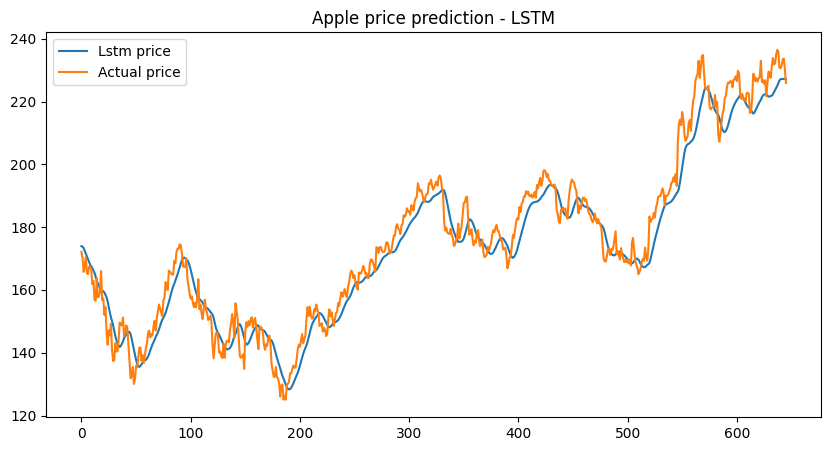

In [52]:
#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(rescaled_predict,label='Lstm price')
plt.plot(rescaled_test,label='Actual price')
plt.legend(loc="upper left")
plt.title("Apple price prediction - LSTM")
plt.show()

In [53]:
#Linear regression model
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

# Make predictions using the linear regression model
linear_predictions = linear_model.predict(x_test)

#Rescale to original values again
rescaled_linear_predictions = scaler.inverse_transform(linear_predictions.reshape(-1, 1))
rescaled_test_values = scaler.inverse_transform(y_test.reshape(-1, 1))

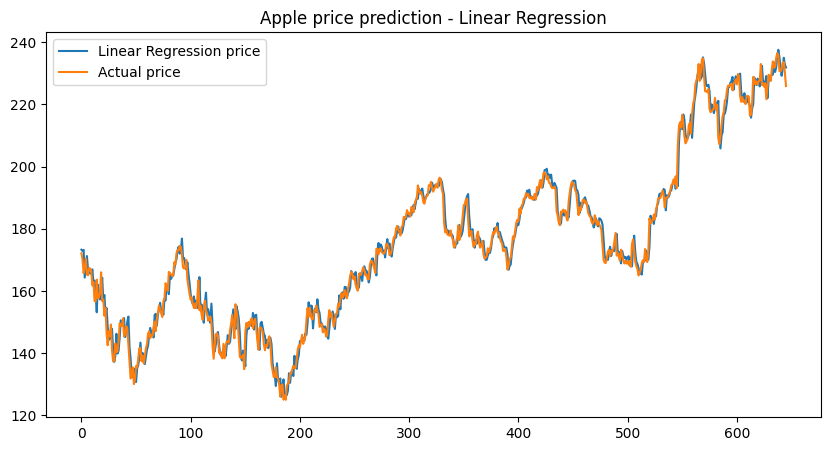

In [54]:
#Plot predictions
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(rescaled_linear_predictions,label='Linear Regression price')
plt.plot(rescaled_test_values,label='Actual price')
plt.legend(loc="upper left")
plt.title("Apple price prediction - Linear Regression")
plt.show()